# <a id='1'>Loan approval case study</a>

**Author:** Tamas Horvath (txttw)

## Business goal
Reduce the number of defaulted loans without significantly reducing business potential by rejecting borrowers who will pay off.

[Presentation to executives](https://github.com/txttw/ds-case-studies/blob/main/loan/Presentation.pdf)

In [71]:
#Importing libraries
import numpy as np #linear algebra
import pandas as pd #data processing, CSV file I/O (e.g. pd.read_csv)
import plotly.offline as py #visualization
import plotly.express as px #visualization
import plotly.graph_objects as go #visualization
py.init_notebook_mode(connected=True) #visualization

## <a id='1.1'>1.1. Data overview</a>

In [72]:
# load data and parse date columns as date
loan = pd.read_csv("loan.csv", dtype={'next_pymnt_d': str, 'issue_d':str}, parse_dates=['next_pymnt_d'])

C:\Users\Tom\AppData\Local\Temp\ipykernel_17364\999368432.py:2: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



In [73]:
print ("Rows:" ,loan.shape[0])
print ("Columns:" ,loan.shape[1], '\n')

Rows: 39717
Columns: 111 



In [74]:
missing_ratio = (loan.isnull().sum() / loan.shape[0] * 100).to_frame(name="missing_ratio_percentage")
missing_ratio.loc[missing_ratio['missing_ratio_percentage'] > 30].sort_values(by='missing_ratio_percentage')

,missing_ratio_percentage
desc,32.585543
mths_since_last_delinq,64.662487
mths_since_last_record,92.985372
next_pymnt_d,97.129693
mths_since_last_major_derog,100.000000
annual_inc_joint,100.000000
dti_joint,100.000000
verification_status_joint,100.000000
tot_coll_amt,100.000000
tot_cur_bal,100.000000


## <a id='1.2'>1.2. Data cleaning</a>

In [75]:
# filter out variables that are not available at loan request time (borrower behaviour vars)
features_to_drop = ['id', 'member_id', 'url', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq', 'open_acc', 'pub_rec',
       'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv',
       'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d']
features_to_keep = list(set(loan.columns.tolist()) - set(features_to_drop))
loan = loan.filter(items=features_to_keep)

# filter out variables with 90%+ missing data
missing_ratio = loan.isnull().sum() / loan.shape[0] * 100;
missing_ratio = missing_ratio.to_frame(name="missing_ratio_percentage")
missing_ratio_below_90perc = missing_ratio[missing_ratio['missing_ratio_percentage']  < 90.0]
loan = loan.filter(items=missing_ratio_below_90perc.index.values)

# filter out variables with not enough unique data (unique values must be > 1)
no_unique = loan.nunique().to_frame('no_unique')
has_unique = no_unique[no_unique['no_unique'] > 1]
loan = loan.filter(items=has_unique.index.values)

# parse month in term and convert to int
loan.term = loan.term.str.replace(r".*(\d{2}).*month.*", r"\1 months", regex=True)

# remove percentage sign and convert to float
loan.int_rate = loan.int_rate.str.replace('%', '')
loan = loan.astype({'int_rate': 'float32'})

# derived vars
loan['installment_monthly_income_ratio'] = loan.installment / (loan.annual_inc / 12)
loan['loan_amount_income_ratio'] = loan.loan_amnt / loan.annual_inc
loan['funded_percentage'] = loan.funded_amnt_inv / loan.loan_amnt
loan['issue_imonth'] = loan['issue_d'].str.replace(r"-\d+", '')

# keep only Fully paid and Charged-off records.
loan = loan[loan['loan_status'].isin(['Fully Paid', 'Charged Off'])]

class LoanStatusFilteredData:
  def __init__(self, data):
    self.all = data
    self.defaulted = data[data['loan_status'].isin(['Charged Off'])]
    self.payed = data[data['loan_status'].isin(['Fully Paid'])]

# filtered by loan status
loan_filtered = LoanStatusFilteredData(loan)

# <a id='2'>2. Exploratory Data Analysis</a>

In [76]:
# placeholder class for results, no computation inside
class LStatusResults:
  def __init__(self, count, payed_ratio, defaulted_ratio):
    self.count_of_feature = count
    self.payed_ratio = payed_ratio
    self.defaulted_ratio = defaulted_ratio

# Makes segmented analysis on continious variables with binning
def segmented_analysis_binned(data, feature, bins): 
    # group data (all, defaulted, payed) by passed feature
    group_all = data.all.groupby([ pd.cut(data.all[feature], bins)], observed=True)
    group_defaulted = data.defaulted.groupby([ pd.cut(data.defaulted[feature], bins)], observed=True)
    group_payed = data.payed.groupby(pd.cut(data.payed[feature], bins), observed=True)
    
    # calculate percentage for groups
    defaulted_ratio = group_defaulted.size() / group_all.size() * 100
    defaulted_ratio.name = "defaulted [%]"
    payed_ratio = group_payed.size() / group_all.size() * 100
    
    # create DataFrame with compined (payed, defaulted) data
    feature_count = pd.DataFrame({'payed':group_payed.size(), 'defaulted':group_defaulted.size()})
    
    # Map indexes to string, used by plot
    feature_count.index = feature_count.index.map(str)
    payed_ratio.index = payed_ratio.index.map(str)
    defaulted_ratio.index = defaulted_ratio.index.map(str)
    
    return LStatusResults(feature_count, payed_ratio, defaulted_ratio)

# Makes segmented analysis on categorical variables with optional filtering of low count variables
def segmented_analysis_categorical(data, feature, size_th = 10):    
    # group data (all, defaulted, payed) by passed feature
    group_all = data.all.groupby(feature, observed=True)
    group_payed = data.payed.groupby(feature, observed=True)
    group_defaulted = data.defaulted.groupby(feature, observed=True)
    
    # calculate percentage for groups
    defaulted_ratio = group_defaulted.size() / group_all.size() * 100
    defaulted_ratio.name = "defaulted [%]"
    payed_ratio = group_payed.size() / group_all.size() * 100

    group_all_th_filter = pd.DataFrame(group_all.size())
    group_all_th_filter = group_all_th_filter[group_all_th_filter[0] < size_th];
    
    # filter categories with less than size_th data points (records)
    for key in group_all_th_filter.index.values:
        payed_ratio.loc[key] = np.NaN
        defaulted_ratio.loc[key] = np.NaN
    
    # create DataFrame with compined (payed, defaulted) data
    feature_count = pd.DataFrame({'payed':group_payed.size(), 'defaulted':group_defaulted.size()})
    
    # Map indexes to string, used by plot
    feature_count.index = feature_count.index.map(str)
    payed_ratio.index = payed_ratio.index.map(str)
    defaulted_ratio.index = defaulted_ratio.index.map(str)
    
    return LStatusResults(feature_count, payed_ratio, defaulted_ratio)

# this function prepares data for box plot
def prepare_feature(data, feature, minval = np.nan, maxval = np.nan):
    payed = data.payed    
    defaulted = data.defaulted
    
    # optional value filtering
    if not np.isnan(minval):
        payed = payed[payed[feature] >= minval]
        defaulted = defaulted[defaulted[feature] >= minval]
    if not np.isnan(maxval):
        payed = payed[payed[feature] <= maxval]
        defaulted = defaulted[defaulted[feature] <= maxval]
    
    # extract feature
    payed = payed[feature]
    defaulted = defaulted[feature]
    
    return pd.DataFrame({
        'payed': payed, 
        'defaulted': defaulted})


## <a id='2.1'>2.1. Charged Off distribution in data</a>

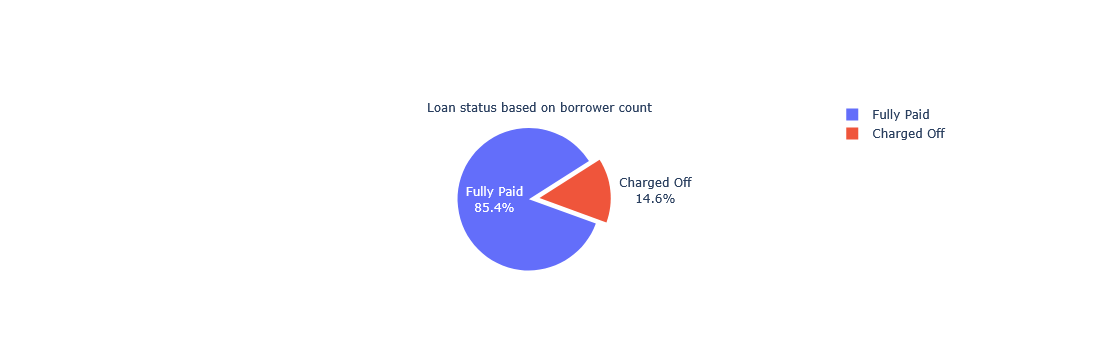

In [77]:
# create loan_status count
loan_statuis_dist = loan.groupby('loan_status').size()
# draw a pie chart to represent payed and defaulted percentage
fig = go.Figure(data=[go.Pie(labels=loan_statuis_dist.index.values, values=loan_statuis_dist, textinfo='label+percent',
    insidetextorientation='radial', pull=[0, 0.15], rotation = 110,  title='Loan status based on borrower count')])
fig.show()

14.6% of borrowers default on the loan.

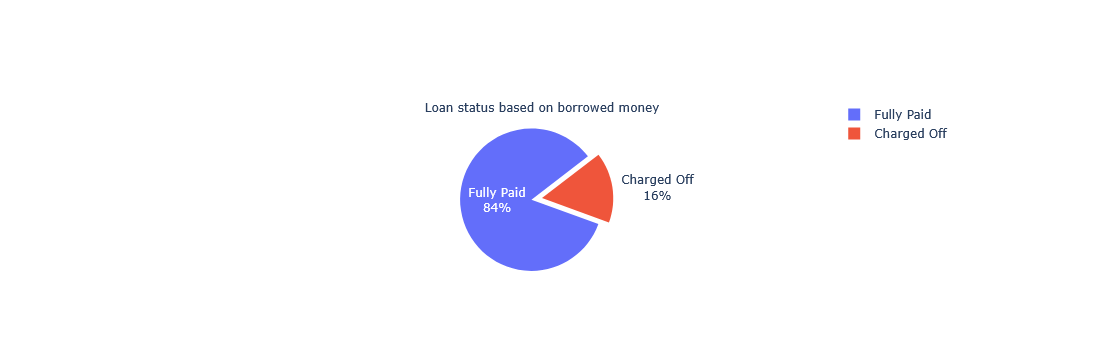

In [78]:
# create loan_amnt sum grouped by loan_status
loan_statuis_dist = loan.groupby('loan_status')['loan_amnt'].sum()
# draw a pie chart to represent payed and defaulted percentage
fig = go.Figure(data=[go.Pie(labels=loan_statuis_dist.index.values, values=loan_statuis_dist, textinfo='label+percent',
    insidetextorientation='radial', pull=[0, 0.15], rotation = 110, title='Loan status based on borrowed money')])
fig.show()

If we check the borrowed amount (defaulted) it is even higher (16%), indicating that the average defaulted loan is slightly higher than the mean of loans. (see detailed distribution later)

**The business goal is to reduce this number without significantly reducing business potencial by rejecting borrowers who will pay off.**

## <a id='2.2'>2.2. Drivers behind Charge Off</a>

### <a id='2.2.1'>2.2.1 Loan amount</a>

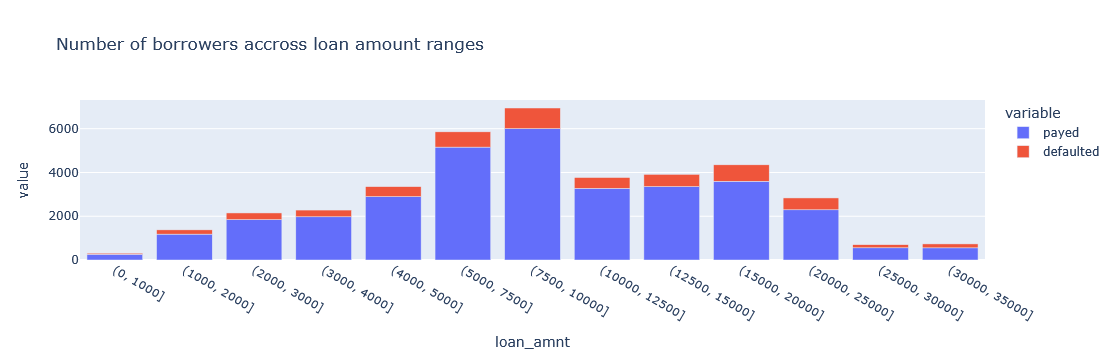

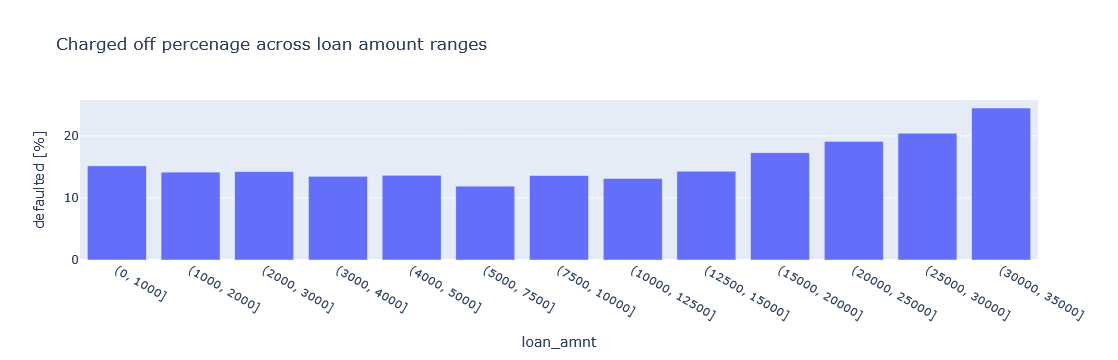

In [79]:
# create bins
bins = [0, 1000, 2000,3000, 4000, 5000, 7500, 10000, 12500, 15000, 20000, 25000, 30000, 35000]
# perform the binned analysis for continious var
results = segmented_analysis_binned(loan_filtered, 'loan_amnt', bins)
# plot bar chart to visualise payed - defaulted count
fig = px.bar(results.count_of_feature, title="Number of borrowers accross loan amount ranges")
fig2 = px.bar(results.defaulted_ratio, y="defaulted [%]", title="Charged off percenage across loan amount ranges")
fig.show()
fig2.show()

The risk of charge off is the lowest around 5000-7500 and start to increase above 15000.

**Recommendations**
- On loans >15000 pay attention on other variables and potentially be more restrictive on the loan ammount.

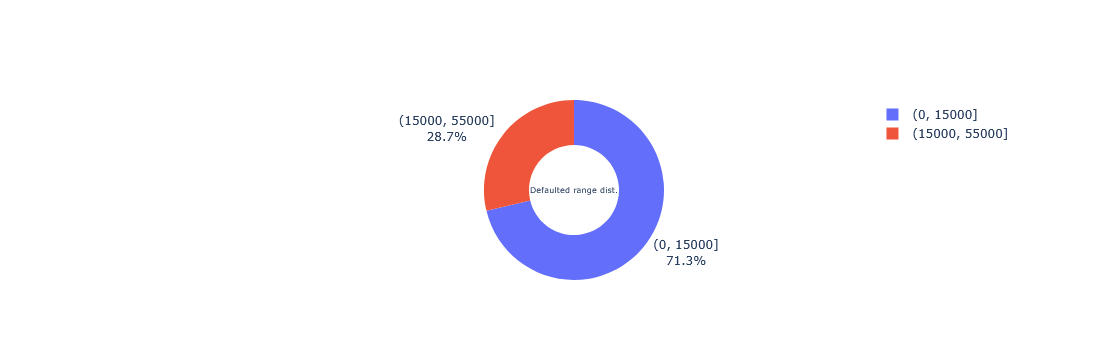

In [80]:
bins = [0, 15000,55000]
# perform the binned analysis for borrower distribution in lower and higher risk range
results = segmented_analysis_binned(loan_filtered, 'loan_amnt', bins)

# plot bar chart to visualise the borrower distribution in lower and higher risk range
fig4 = go.Figure(data=[go.Pie(labels=results.count_of_feature.index.values, values=results.count_of_feature['defaulted'], textinfo='label+percent',
    insidetextorientation='radial', hole=.5,  title='Defaulted range dist.')])
fig4.show()


Almost 3/4 of the loans are from the <15000 range. Currently these loans are in the lower risk range. If the company starts to target a market of higher loans, should follow the above mentioned recommendations.

### <a id='2.2.2'>2.2.2 Annual Income</a>

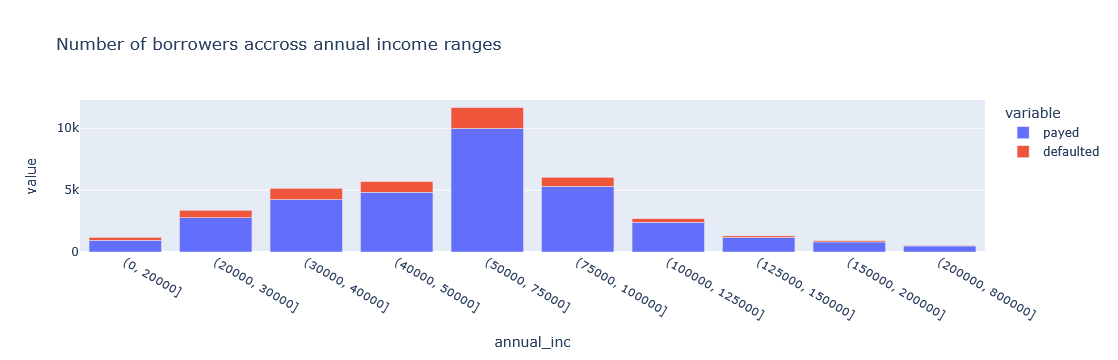

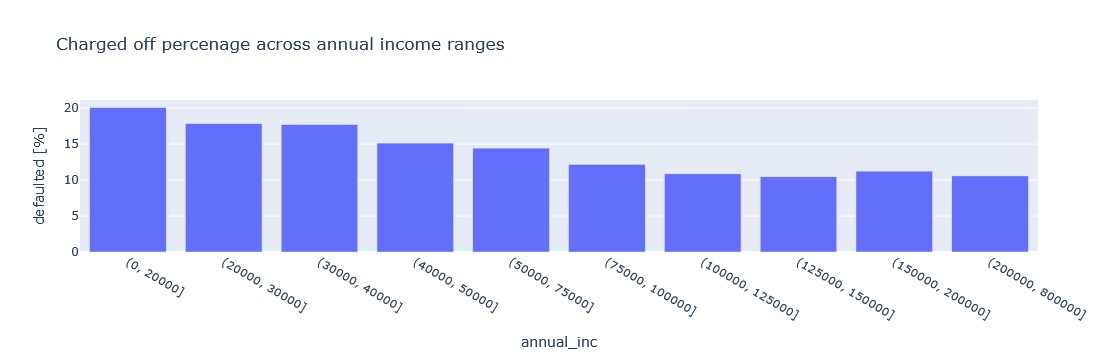

In [81]:
# create bins
bins = [0, 20000, 30000, 40000, 50000, 75000, 100000, 125000, 150000, 200000, 800000]
# perform the binned analysis for continious var 'loan_amnt'
results = segmented_analysis_binned(loan_filtered, 'annual_inc', bins)
# plot bar chart to visualise payed - defaulted count
fig = px.bar(results.count_of_feature, title="Number of borrowers accross annual income ranges")
fig2 = px.bar(results.defaulted_ratio, y="defaulted [%]", title="Charged off percenage across annual income ranges")
fig.show()
fig2.show()

In general, lower annual income presents higher risk of default. Above 100k, income increase does not further decrease the risk of default.

#### Check how the borrowed amount relative to annual income affects default rate (percentage)

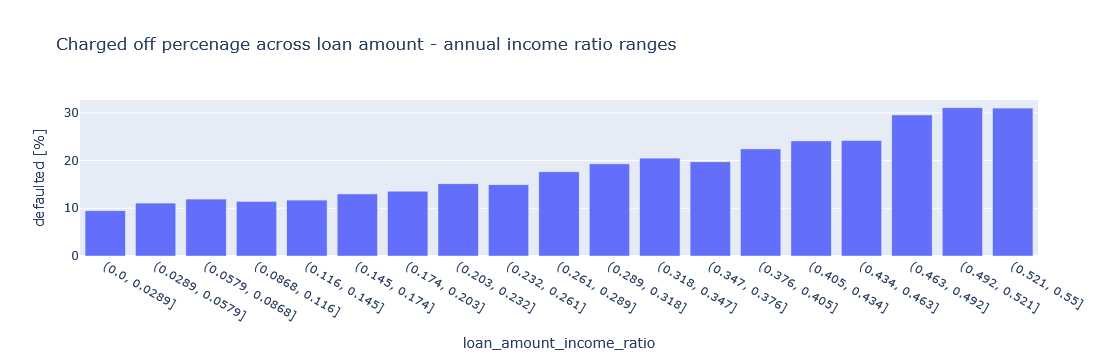

In [82]:
# create bins
bins = np.linspace(0, 0.55, num=20)
# perform the binned analysis for continious var 'loan_amnt'
results = segmented_analysis_binned(loan_filtered, 'loan_amount_income_ratio', bins)
# plot bar chart to visualise percentage of defaulted based on loan amount - annual income ratio (loan_amnt / annual_income)
fig2 = px.bar(results.defaulted_ratio, y="defaulted [%]", title="Charged off percenage across loan amount - annual income ratio ranges")
fig2.show()


As the borrowed amount - annual income ratio (borrowed / annual income) increases the risk of default increases as well.

**Recommendation**
- for ratio >0.26 check other indicators and potentially decrease the accepted loan amount

### <a id='2.2.3'>2.2.3 Installment</a>

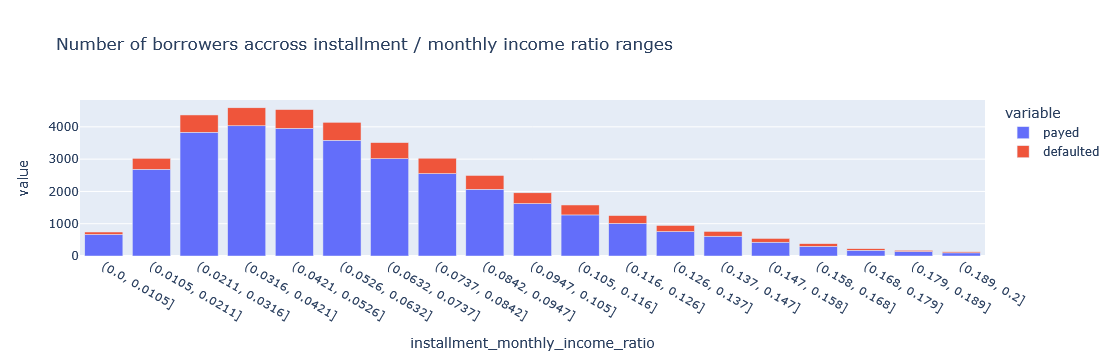

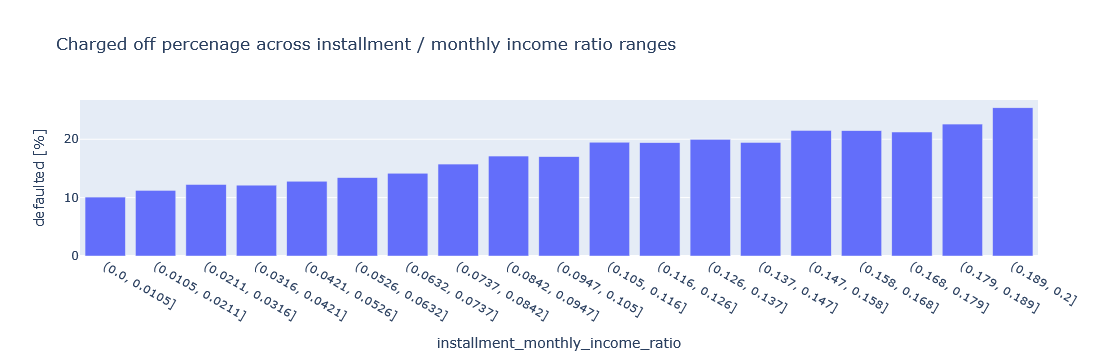

In [83]:
# create bins
bins = np.linspace(0, 0.2, num=20)
# perform the binned analysis for continious var 'installment_monthly_income_ratio'
results = segmented_analysis_binned(loan_filtered, 'installment_monthly_income_ratio', bins)
fig = px.bar(results.count_of_feature, title="Number of borrowers accross installment / monthly income ratio ranges")
# plot bar chart to visualise percentage of defaulted based on loan amount - annual income ratio (loan_amnt / annual_income)
fig2 = px.bar(results.defaulted_ratio, y="defaulted [%]", title="Charged off percenage across installment / monthly income ratio ranges")
fig.show()
fig2.show()

The number of borrowers accross installment / monthly income ratio ranges follows normal distributon.

As the monthly instalment cost increase relative to the borrower's monthly income the chanche of default increases.

**Recommendation**
- decrease the accepted loan amount therefore the ratio will decrease
- offering longer term might decrease ratio but * *see following analysis*

### How longer term affects default ratio respect to installment / monthly income ratio

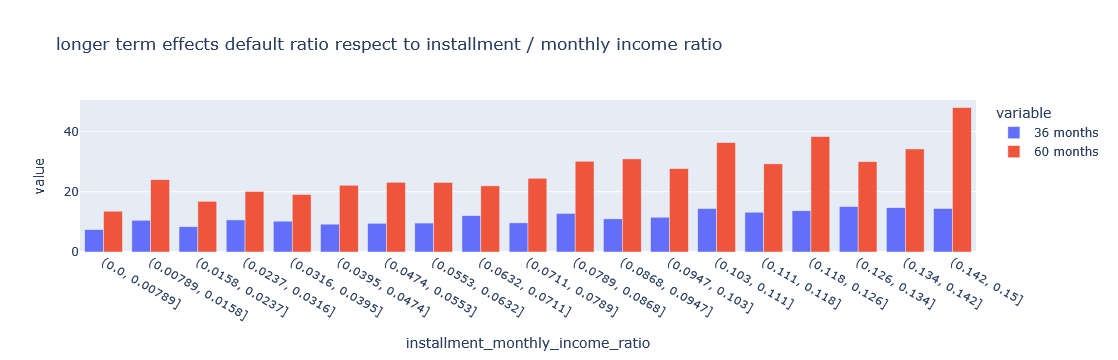

In [84]:
loan_term_36 = loan[loan['term'] == '36 months']
loan_term_60 = loan[loan['term'] == '60 months']
# create bins
bins = np.linspace(0, 0.15, num=20)
# perform the binned analysis for continious var 'installment_monthly_income_ratio'
results_36 = segmented_analysis_binned(LoanStatusFilteredData(loan_term_36), 'installment_monthly_income_ratio', bins)
results_60 = segmented_analysis_binned(LoanStatusFilteredData(loan_term_60), 'installment_monthly_income_ratio', bins)
# plot bar chart to visualise percentage of defaulted based on 
data_term = {'36 months':results_36.defaulted_ratio, '60 months':results_60.defaulted_ratio}
fig2 = px.bar(data_term, barmode='group',  title="longer term effects default ratio respect to installment / monthly income ratio")
fig2.show()

Based on the data, longer term loans has a significantly higher risk of default.

**Conclusion**
- Even with lower installment / monthly income ratio the chance of default is higher for longer term. It is **not recommended** to offer **significantly** longer term for those who has higher installment / monthly income ratio. 
- 40 or 48 months might be an option, but it needs data to prove.

### <a id='2.2.4'>2.2.4 Term</a>

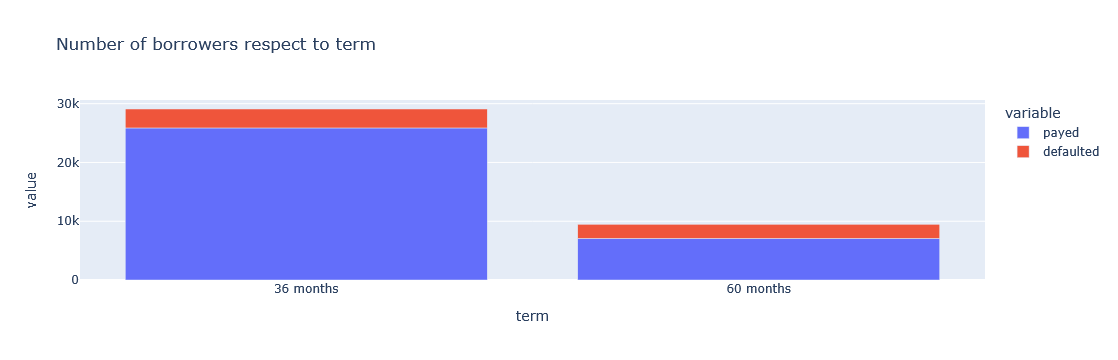

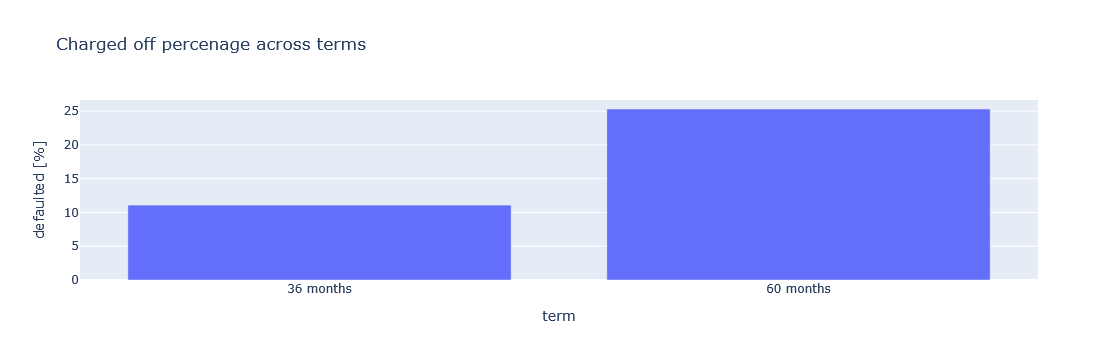

In [85]:
results = segmented_analysis_categorical(loan_filtered, 'term')
# plot bar chart to visualise 
fig = px.bar(results.count_of_feature, title="Number of borrowers respect to term")
fig2 = px.bar(results.defaulted_ratio, y="defaulted [%]", title="Charged off percenage across terms")
fig.show()
fig2.show()

In general longer term (60 months) has significanthly higher (2x) risk of default.

**Recommendation**
- Decrease the term to 36 if possible or decrease the loan amount to fit to the 36 months installment. *As shown later decresing the loan ammount keeping the 60 months does not decrease the risk of default*
- Check other risk factors and reject the loan if 60 months term coexist with them

### Defaulted percentage respect to Term - Income

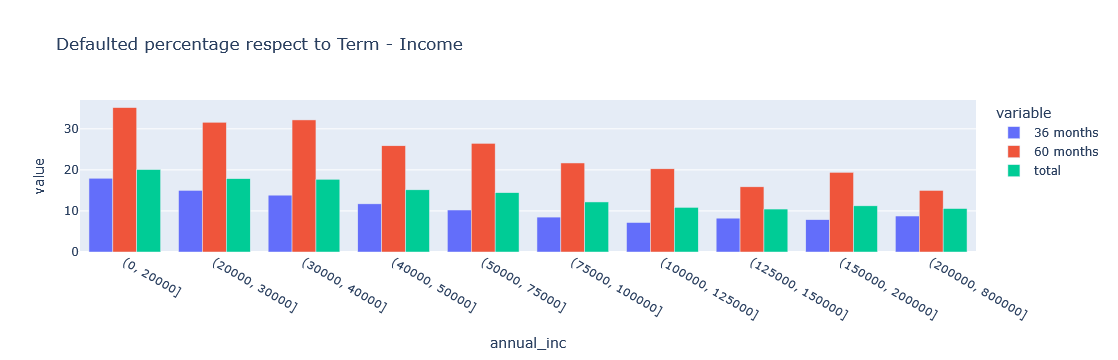

In [86]:
loan_term_36 = loan[loan['term'] == '36 months']
loan_term_60 = loan[loan['term'] == '60 months']
# create bins
bins = [0, 20000, 30000, 40000, 50000, 75000, 100000, 125000, 150000, 200000, 800000]
# perform the binned analysis for continious var 
results = segmented_analysis_binned(loan_filtered, 'annual_inc', bins)
results_36 = segmented_analysis_binned(LoanStatusFilteredData(loan_term_36), 'annual_inc', bins)
results_60 = segmented_analysis_binned(LoanStatusFilteredData(loan_term_60), 'annual_inc', bins)
# plot bar chart to visualise percentage of defaulted based on 
data_term = {'36 months':results_36.defaulted_ratio, '60 months':results_60.defaulted_ratio, 'total':results.defaulted_ratio}
fig2 = px.bar(data_term, barmode='group', title="Defaulted percentage respect to Term - Income")
fig2.show()

Anual income increase lowers the risk for both terms (36 months, 60 months), indicating that annual income feature (variable) is a consistent predictor.

### Defaulted percentage respect to Term - Loan amount

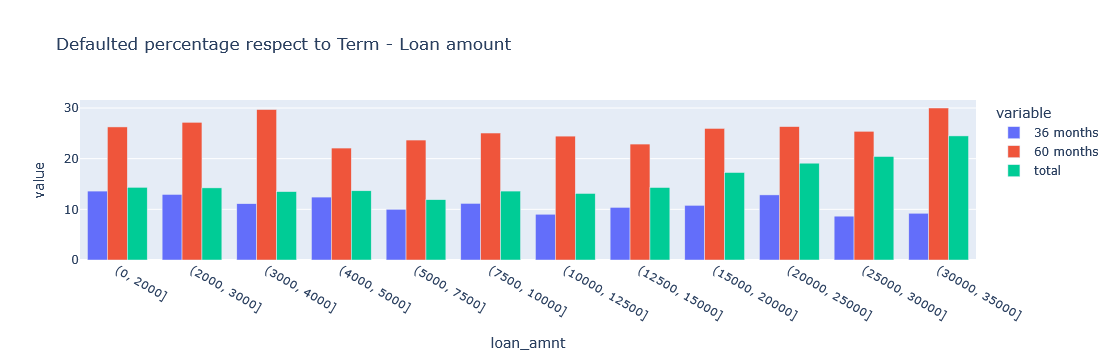

In [87]:
loan_term_36 = loan[loan['term'] == '36 months']
loan_term_60 = loan[loan['term'] == '60 months']
# create bins
bins = [0, 2000,3000, 4000, 5000, 7500, 10000, 12500, 15000, 20000, 25000, 30000, 35000]
# perform the binned analysis for continious var 
results = segmented_analysis_binned(loan_filtered, 'loan_amnt', bins)
results_36 = segmented_analysis_binned(LoanStatusFilteredData(loan_term_36), 'loan_amnt', bins)
results_60 = segmented_analysis_binned(LoanStatusFilteredData(loan_term_60), 'loan_amnt', bins)
# plot bar chart to visualise percentage of defaulted based on 
data_term = {'36 months':results_36.defaulted_ratio, '60 months':results_60.defaulted_ratio, 'total':results.defaulted_ratio}
fig2 = px.bar(data_term, barmode='group', title="Defaulted percentage respect to Term - Loan amount")
fig2.show()


Decresing the loan ammount keeping the 60 months term does not decrease the risk of default.

### <a id='2.2.5'>2.2.5 Grade and Subgrade</a>

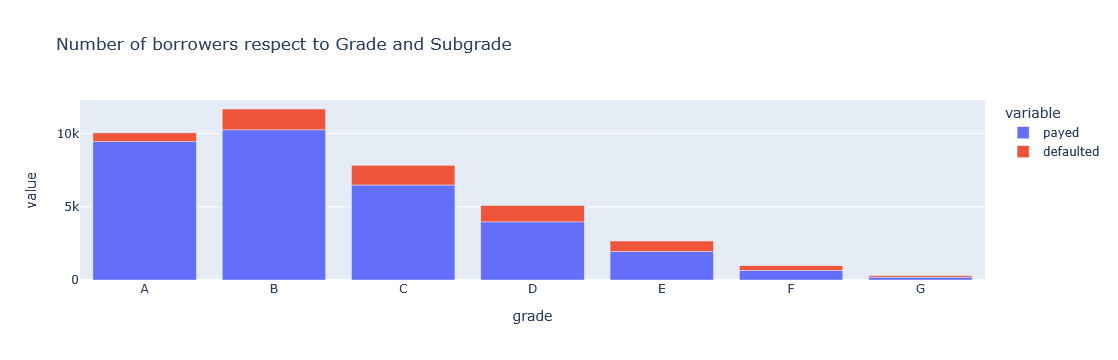

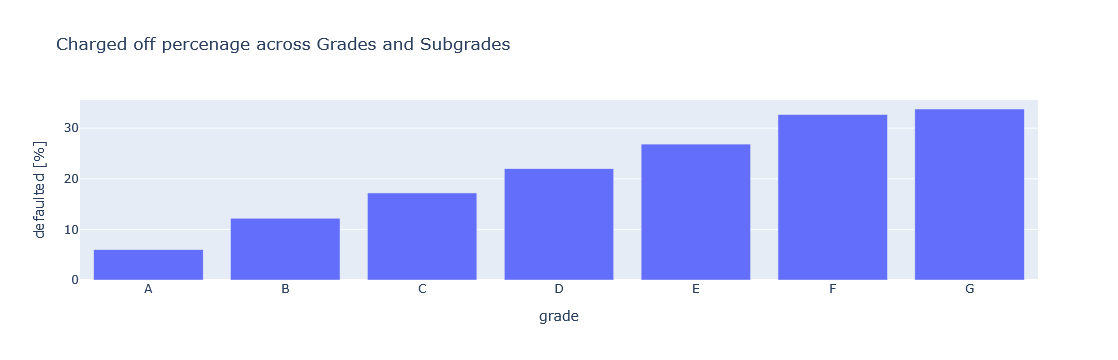

In [88]:
results = segmented_analysis_categorical(loan_filtered, 'grade')
# plot bar chart to visualise 
fig = px.bar(results.count_of_feature, title="Number of borrowers respect to Grade and Subgrade")
fig2 = px.bar(results.defaulted_ratio, y="defaulted [%]", title="Charged off percenage across Grades and Subgrades")
fig.show()
fig2.show()

Grade is a strong indicator of charge off

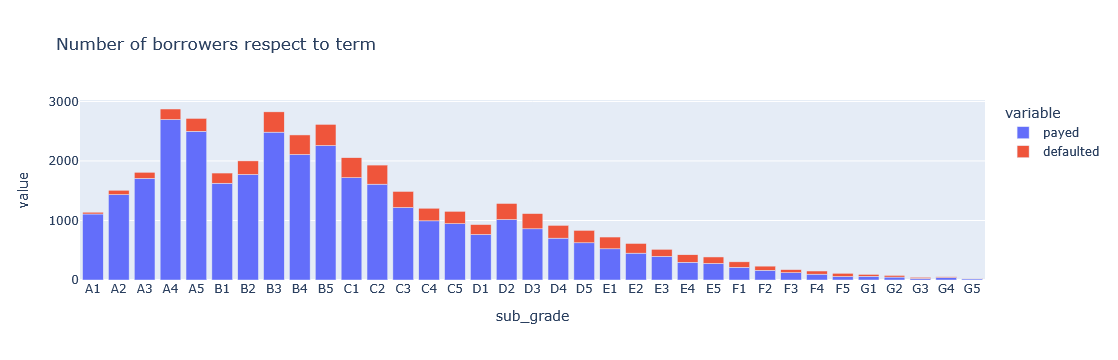

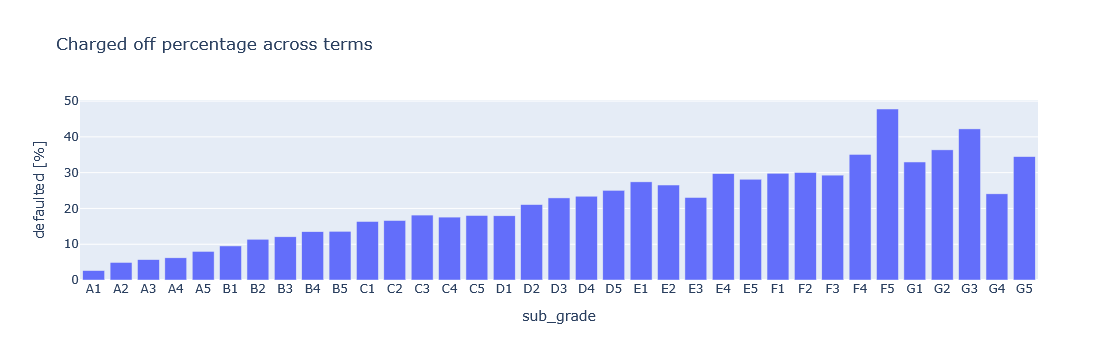

In [89]:
results = segmented_analysis_categorical(loan_filtered, 'sub_grade')
# plot bar chart to visualise 
fig = px.bar(results.count_of_feature, title="Number of borrowers respect to term")
fig2 = px.bar(results.defaulted_ratio, y="defaulted [%]", title="Charged off percentage across terms")
fig.show()
fig2.show()

Sub Grade is a strong indicator of charge off. It provides reliable and consistent prediction of default between A-D. E and above subgrade does not give reliable indication.

**Recommendation**
- Use grade and subgrade as a risk indicator between A-D.
- E and above use grade subgrade dose not consistent.
- As Grade decrease (A->G) consider other factors and decrease the loan amount or reject the loan.

### Grade effect on default respect to annual income

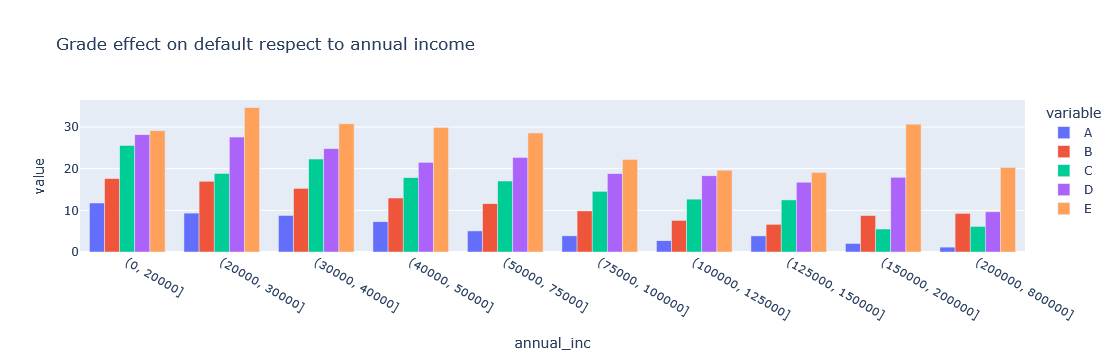

In [90]:
def analyse_grade_binned(data, grade, feature, bins):    
    # filter by grade
    loan_grade = data[data['grade'] == grade]
    # perform the binned analysis for continious var
    return segmented_analysis_binned(LoanStatusFilteredData(loan_grade), feature, bins)

# create bins
bins = [0, 20000, 30000, 40000, 50000, 75000, 100000, 125000, 150000, 200000, 800000]

# plot bar chart to visualise percentage of defaulted based on 
data_grade = {'A':analyse_grade_binned(loan, 'A', 'annual_inc', bins).defaulted_ratio, 
              'B':analyse_grade_binned(loan, 'B', 'annual_inc', bins).defaulted_ratio,
              'C':analyse_grade_binned(loan, 'C', 'annual_inc', bins).defaulted_ratio,
              'D':analyse_grade_binned(loan, 'D', 'annual_inc', bins).defaulted_ratio,
              'E':analyse_grade_binned(loan, 'E', 'annual_inc', bins).defaulted_ratio,             
              
              }
fig2 = px.bar(data_grade, barmode='group', title="Grade effect on default respect to annual income")
fig2.show()

Both annual income and grade are strong and reliable indicators. F, G not included in the analysis becose of low amount of data points per bin. But data shows that grade D, E have are less consistent and incur higher risk.

**Recommendation**
- Annual income used in conjunction with grade can be a good predictor of default

### <a id='2.2.6'>2.2.6 Purpose</a>

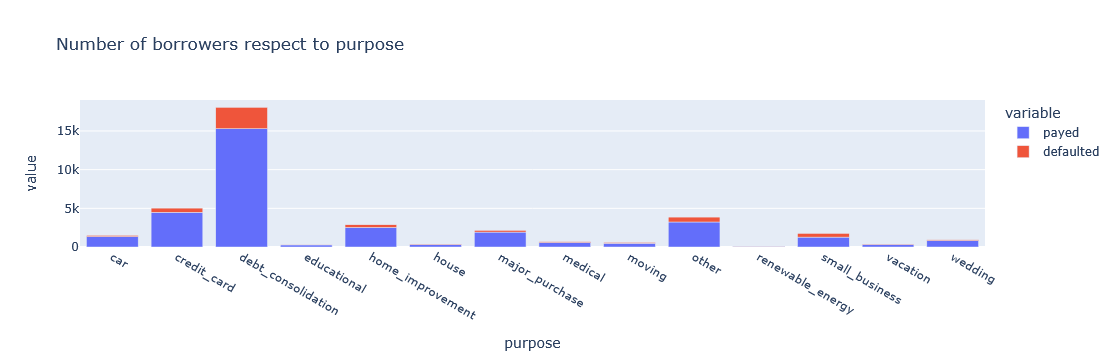

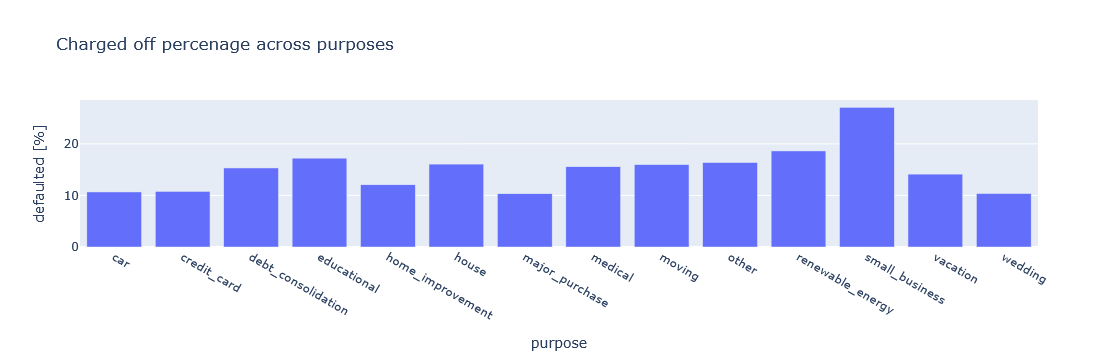

In [91]:
results = segmented_analysis_categorical(loan_filtered, 'purpose')
# plot bar chart to visualise
fig = px.bar(results.count_of_feature, title="Number of borrowers respect to purpose")
fig2 = px.bar(results.defaulted_ratio, y="defaulted [%]", title="Charged off percenage across purposes")
fig.show()
fig2.show()

Small business loans carry a significantly higher risk of default.

**Recommendation**
- Check other variables in case of small business loans

### Possible effects of lower loan amount in case of higher risk 'purpose'

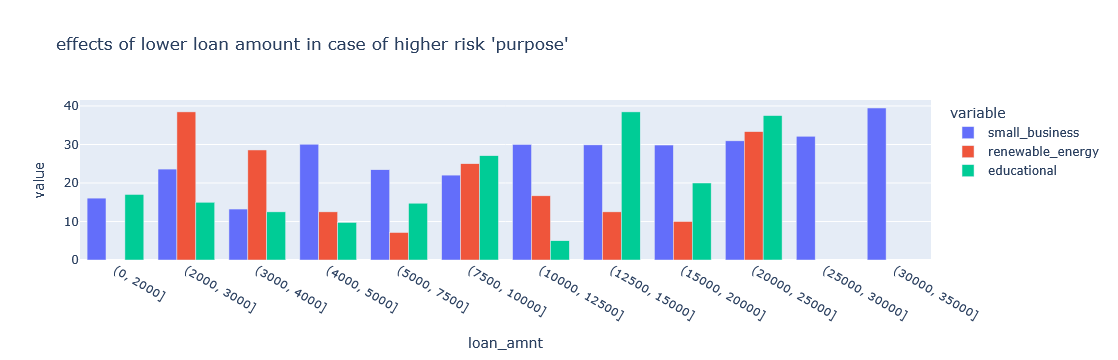

In [92]:
def analyse_purpose_binned(data, purpose, feature, bins):    
    # filter by grade
    loan_grade = data[data['purpose'] == purpose]
    # perform the binned analysis for continious var
    return segmented_analysis_binned(LoanStatusFilteredData(loan_grade), feature, bins)

# create bins
bins = [0, 2000,3000, 4000, 5000, 7500, 10000, 12500, 15000, 20000, 25000, 30000, 35000]

# plot bar chart to visualise percentage of defaulted based on 
data_grade = {'small_business':analyse_purpose_binned(loan, 'small_business', 'loan_amnt', bins).defaulted_ratio, 
               'renewable_energy':analyse_purpose_binned(loan, 'renewable_energy', 'loan_amnt', bins).defaulted_ratio,
              'educational':analyse_purpose_binned(loan, 'educational', 'loan_amnt', bins).defaulted_ratio,
              }
fig2 = px.bar(data_grade, barmode='group', title="effects of lower loan amount in case of higher risk 'purpose'")
fig2.show()

**Conclusion**
- small business: Lower loan amount can slightly decrease the risk.
- educational: Lower loan amount can decrease the risk.
- renewable energy: Lower loan amount can increase the risk.

### <a id='2.2.7'>2.2.7 Funded percentage</a>

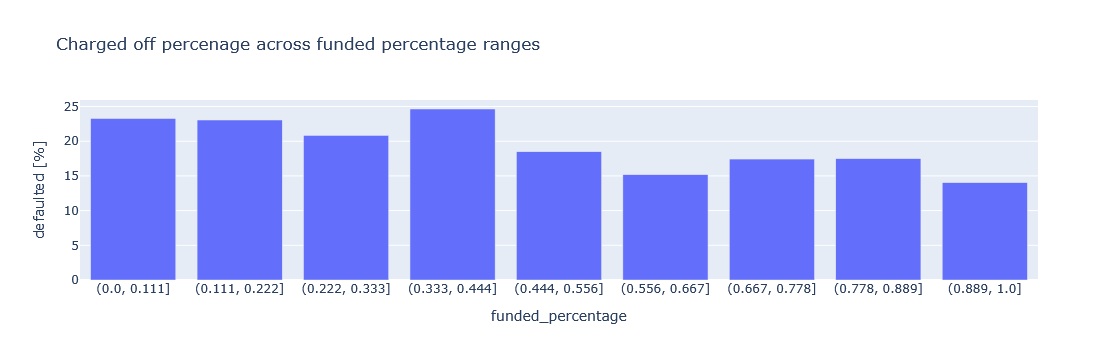

In [93]:
# create bins
bins = np.linspace(0, 1, num=10)
# perform the binned analysis for continious var 
results = segmented_analysis_binned(loan_filtered, 'funded_percentage', bins)
# plot bar chart to visualise percentage of defaulted based on 
fig2 = px.bar(results.defaulted_ratio, y="defaulted [%]", title="Charged off percenage across funded percentage ranges")
fig2.show()


Moderate underfunding (not providing the requested loan amount) does not increase the risk of default.
Only substantial underfunding >50% can increase the risk.

### <a id='2.2.8'>2.2.8 Employment length</a>

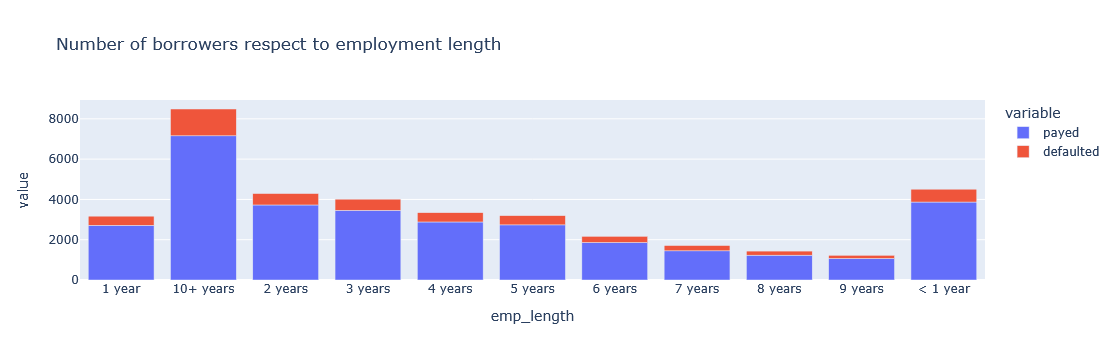

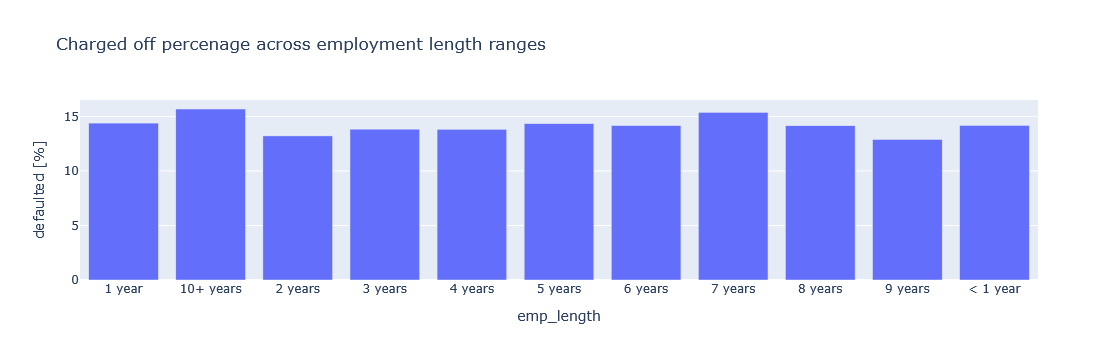

In [94]:
results = segmented_analysis_categorical(loan_filtered, 'emp_length')
# plot bar chart to visualise payed - defaulted count
fig = px.bar(results.count_of_feature, title="Number of borrowers respect to employment length")
fig2 = px.bar(results.defaulted_ratio, y="defaulted [%]", title="Charged off percenage across employment length ranges")
fig.show()
fig2.show()

**Conclusion**
- Employment length is not a good predictor of default.
- Not recommended to use it.

### <a id='2.2.9'>2.2.9 Interest rate</a>

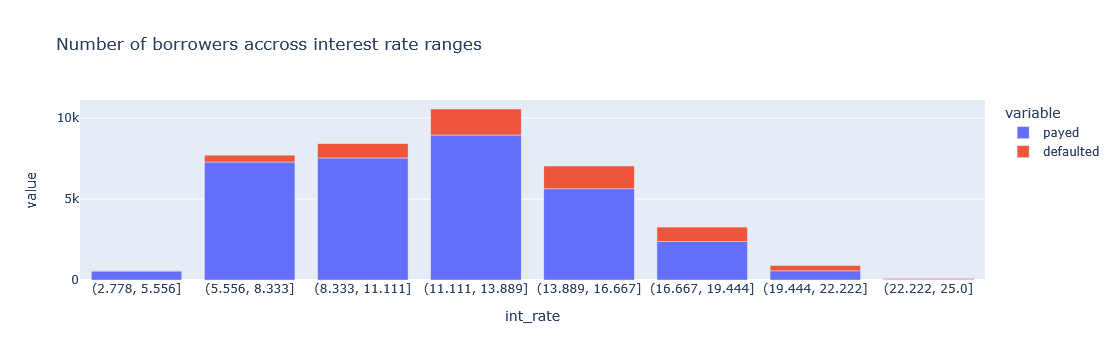

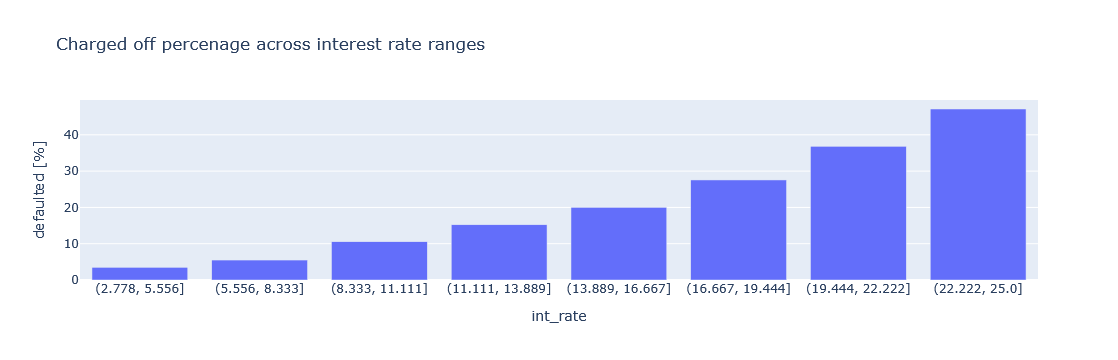

In [95]:
# create bins
bins = np.linspace(0, 25, num=10)
# perform the binned analysis for continious var 
results = segmented_analysis_binned(loan_filtered, 'int_rate', bins)
fig = px.bar(results.count_of_feature, title="Number of borrowers accross interest rate ranges")
# plot bar chart to visualise percentage of defaulted based on 
fig2 = px.bar(results.defaulted_ratio, y="defaulted [%]", title="Charged off percenage across interest rate ranges")
fig.show()
fig2.show()

**Conclusion**
- Interest rate is a good predictor of risk. High interest rate has significantly higher default rate. It is a very strong indicator.

**Recommendation**
- If high interest rate combined with other strong negative predictors do not approve the loan.

### <a id='2.2.10'>2.2.10 DTI</a>

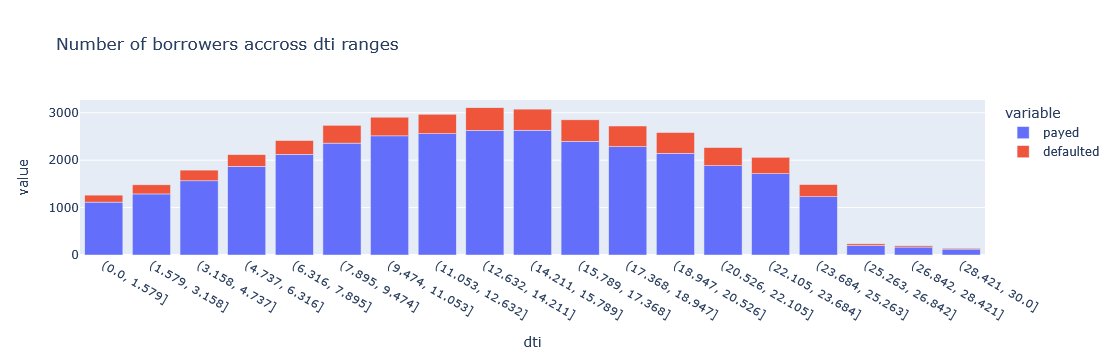

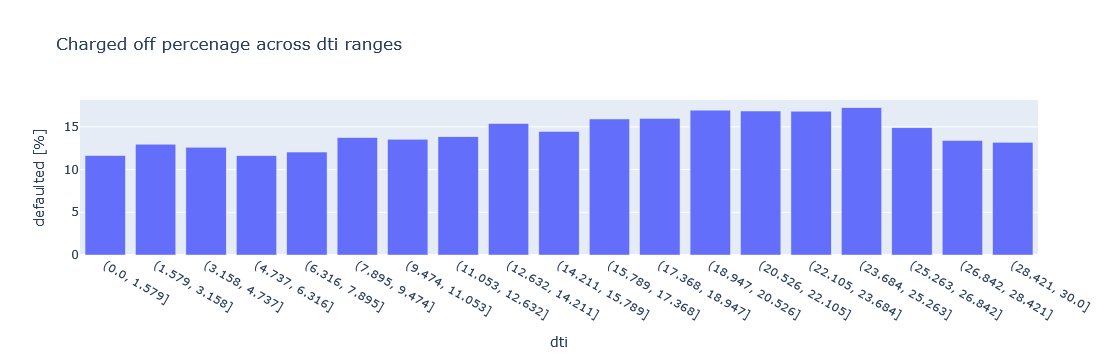

In [96]:
# create bins
bins = np.linspace(0, 30, num=20)
# perform the binned analysis for continious var 
results = segmented_analysis_binned(loan_filtered, 'dti', bins)
fig = px.bar(results.count_of_feature, title="Number of borrowers accross dti ranges")
# plot bar chart to visualise percentage of defaulted based 
fig2 = px.bar(results.defaulted_ratio, y="defaulted [%]", title="Charged off percenage across dti ranges")
fig.show()
fig2.show()

DTI between 15 and 25 shows a higher risk of default. Above 25 default ratio significantly drops. More data record in this range could reinforce this observation.

**Recommendation**
- Not the best predictor, but can be used in conjunction with other stronger predictors.